In [2]:
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\Stefan\AppData\Local\Programs\Python\Python37\lib\site-packages\en_core_web_sm
-->
C:\Users\Stefan\AppData\Local\Programs\Python\Python37\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


You do not have sufficient privilege to perform this operation.


In [4]:
import spacy
import torch
import torchtext
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Twitter Sentiment Analysis Dataset
Source: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [5]:
tweets = pd.read_csv('datasets/tweets/tweets.csv', error_bad_lines = False)

#tweets = tweets.head(50000)

tweets.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,neg,Sentiment140,is so sad for my APL frie...
1,2,neg,Sentiment140,I missed the New Moon trail...
2,3,pos,Sentiment140,omg its already 7:30 :O
3,4,neg,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,5,neg,Sentiment140,i think mi bf is cheating on me!!! ...


The dataframe consists of 4 columns and we want to use only ‘Sentiment’ and ‘SentimentText’.

In [6]:
tweets  = tweets.drop(columns = ['ItemID', 'SentimentSource'], axis = 1)

tweets.head()

,Sentiment,SentimentText
0,neg,is so sad for my APL frie...
1,neg,I missed the New Moon trail...
2,pos,omg its already 7:30 :O
3,neg,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,neg,i think mi bf is cheating on me!!! ...


In [7]:
tweets.shape

(50000, 2)

In [8]:
tweets['Sentiment'].unique()

array(['neg', 'pos'], dtype=object)

In [9]:
tweets.Sentiment.value_counts()

pos    26921
neg    23079
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

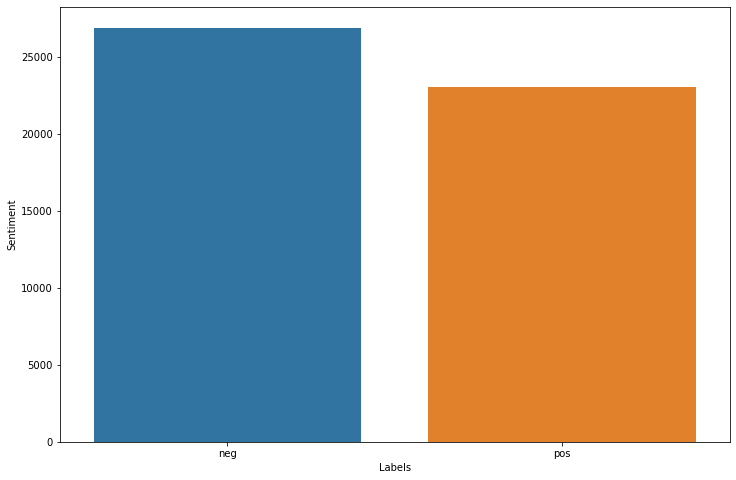

In [10]:
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())

ax.set(xlabel='Labels')

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets, test_size=0.2, random_state=42)

In [12]:
train.reset_index(drop=True), test.reset_index(drop=True)

(      Sentiment                                      SentimentText
 0           pos  @amyrenea omg so am I lol I fell asleep when i...
 1           neg               @Adrienne_Bailon I want a shout out 
 2           neg  @Anonymousboy03 Plans for school stuff &amp; a...
 3           neg  ... has hit a writer's block .. am loosing my ...
 4           neg  ... trying to find people I know! I`m bored, i...
 ...         ...                                                ...
 39995       pos   #robotpickuplines are so funny. check them out. 
 39996       pos  @annyo84 awh thankss.  yeah, i understand what...
 39997       pos  @AmbiguityX ohh you're in twin cities?  i luv ...
 39998       neg   Dinara lost again in Roland Garros. Why the S...
 39999       pos  *yawn* fucking time zones shit. I'm really sic...
 
 [40000 rows x 2 columns],
      Sentiment                                      SentimentText
 0          pos  @aimeesays aww i hope it does fly by because J...
 1          neg  #don

In [13]:
train.head()

,Sentiment,SentimentText
39087,pos,@amyrenea omg so am I lol I fell asleep when i...
30893,neg,@Adrienne_Bailon I want a shout out
45278,neg,@Anonymousboy03 Plans for school stuff &amp; a...
16398,neg,... has hit a writer's block .. am loosing my ...
13653,neg,"... trying to find people I know! I`m bored, i..."


In [14]:
train.shape, test.shape

((40000, 2), (10000, 2))

In [15]:
train.to_csv('datasets/tweets/train_tweets.csv', index=False)
test.to_csv('datasets/tweets/test_tweets.csv', index=False)

In [16]:
!ls datasets/tweets

test_tweets.csv
train_tweets.csv
tweets.csv


#### removing non alphanumeric character

In [17]:
def tweet_clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()

####  processing and tokenization, so that it can be converted into indices.

In [18]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [19]:
tokenizer("pytorch is #awesome!!")

['pytorch', 'is', 'awesome']

In [20]:
TEXT = torchtext.data.Field(tokenize = tokenizer)

LABEL = torchtext.data.LabelField(dtype = torch.float)

In [21]:
datafields = [('Sentiment', LABEL), ('SentimentText', TEXT)]

#### TabularDataset to read csv files and process them

In [22]:
trn, tst = torchtext.data.TabularDataset.splits(path = 'datasets/tweets/', 
                                                train = 'train_tweets.csv',
                                                test = 'test_tweets.csv',    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)

In [23]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 40000
Number of testing examples: 10000


In [24]:
vars(trn.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['amyrenea',
  'omg',
  'so',
  'am',
  'i',
  'lol',
  'i',
  'fell',
  'asleep',
  'when',
  'it',
  'was',
  'on',
  'last',
  'night',
  'so',
  'now',
  'i',
  'get',
  'to',
  'finish',
  'it']}

In [25]:
vars(tst.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['aimeesays',
  'aww',
  'i',
  'hope',
  'it',
  'does',
  'fly',
  'by',
  'because',
  'jt',
  'episodes',
  'are',
  'usually',
  'really',
  'good',
  'and',
  'it',
  's',
  'early',
  'but',
  'so',
  'far',
  'this',
  'ep',
  'hassn',
  't',
  'disappointed']}

#### Building vocabulary using glove.6B.100d

In [26]:
TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)

In [27]:
print(TEXT.vocab.freqs.most_common(50))

[('i', 25644), ('the', 12219), ('to', 12111), ('you', 10723), ('a', 9197), ('it', 8440), ('and', 6889), ('my', 6208), ('quot', 5582), ('s', 5564), ('that', 5306), ('is', 5203), ('for', 4971), ('in', 4852), ('t', 4844), ('m', 4683), ('me', 4588), ('of', 4331), ('on', 3918), ('have', 3752), ('so', 3612), ('but', 3506), ('be', 2932), ('not', 2887), ('was', 2775), ('just', 2724), ('can', 2523), ('do', 2418), ('are', 2351), ('your', 2320), ('with', 2269), ('good', 2203), ('like', 2173), ('at', 2131), ('no', 2119), ('this', 2093), ('all', 2069), ('up', 2066), ('now', 2063), ('get', 2044), ('we', 1988), ('u', 1890), ('love', 1885), ('lol', 1864), ('too', 1826), ('what', 1760), ('out', 1742), ('know', 1664), ('nt', 1608), ('amp', 1539)]


In [28]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'the', 'to', 'you', 'a', 'it', 'and', 'my']


In [29]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


#### Loading the data in batches (BucketIterator() dataloader - to group same length sentences )

In [30]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size = 64,
                                sort_key=lambda x: len(x.SentimentText),
                                sort_within_batch=False)

#### RNN architecture


In [31]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        output, hidden = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
       
        return self.fc(hidden.squeeze(0))

In [32]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim = 20
output_dim = 1

n_layers = 2
bidirectional = True

dropout = 0.5

In [33]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)

In [34]:
model

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim]

In [35]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


replacing the initial weights of the embedding layer with the pre-trained embeddings.

In [36]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.2932, -1.4328, -0.0502,  ..., -0.4358,  0.0277, -1.2281],
        [-0.2607, -0.3080,  0.7337,  ...,  0.4167,  0.5066, -1.4307],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.6137,  0.3310,  0.1758,  ...,  1.4781,  0.1865, -1.5560],
        [ 0.3671,  0.5979, -0.5116,  ...,  0.6914,  0.1968, -1.0107],
        [ 1.2596, -0.9782,  1.5508,  ..., -0.8135,  1.0153, -1.3793]])

In [37]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.6137,  0.3310,  0.1758,  ...,  1.4781,  0.1865, -1.5560],
        [ 0.3671,  0.5979, -0.5116,  ...,  0.6914,  0.1968, -1.0107],
        [ 1.2596, -0.9782,  1.5508,  ..., -0.8135,  1.0153, -1.3793]])


#### Train the Model

In [38]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

#### training the model

In [39]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
num_epochs = 20

for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.634 | Train Acc: 63.20% |
| Epoch: 02 | Train Loss: 0.536 | Train Acc: 73.62% |
| Epoch: 03 | Train Loss: 0.491 | Train Acc: 76.36% |
| Epoch: 04 | Train Loss: 0.466 | Train Acc: 78.35% |
| Epoch: 05 | Train Loss: 0.442 | Train Acc: 79.62% |
| Epoch: 06 | Train Loss: 0.421 | Train Acc: 80.88% |
| Epoch: 07 | Train Loss: 0.405 | Train Acc: 81.87% |
| Epoch: 08 | Train Loss: 0.389 | Train Acc: 82.82% |
| Epoch: 09 | Train Loss: 0.374 | Train Acc: 83.70% |
| Epoch: 10 | Train Loss: 0.359 | Train Acc: 84.41% |
| Epoch: 11 | Train Loss: 0.348 | Train Acc: 84.98% |
| Epoch: 12 | Train Loss: 0.337 | Train Acc: 85.66% |
| Epoch: 13 | Train Loss: 0.326 | Train Acc: 86.30% |
| Epoch: 14 | Train Loss: 0.311 | Train Acc: 87.06% |
| Epoch: 15 | Train Loss: 0.303 | Train Acc: 87.22% |
| Epoch: 16 | Train Loss: 0.292 | Train Acc: 87.79% |
| Epoch: 17 | Train Loss: 0.281 | Train Acc: 88.20% |
| Epoch: 18 | Train Loss: 0.273 | Train Acc: 88.68% |
| Epoch: 19 | Train Loss: 0.

### Testing the model

In [49]:
epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():

    for batch in test_iterator:

        predictions = model(batch.SentimentText).squeeze(1)

        loss = criterion(predictions, batch.Sentiment)

        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum()/len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()


test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.584 | Test Acc: 75.28%


#### Input

In [50]:
sentence = 'I hate that show' 

#Run again for "That movie was really nice"
#Run again for "I hate that show but recently it has been quite good"
#Run again for "That movie was decent but kind of fizzled out towards the end"

In [51]:
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]

In [52]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]

In [53]:
tensor = torch.LongTensor(indexed)

In [54]:
tensor = tensor.unsqueeze(1)

In [55]:
prediction = torch.sigmoid(model(tensor))

In [56]:
prediction.item()

0.9284198880195618